### Showcase of Jack's rough draft of the laz -> DSM pipeline

Based on the lidar_tools workflow at https://github.com/uw-cryo/lidar_tools/blob/main/notebooks/DSM_processing_reproj.ipynb

* only works for a singular, local input laz
* relevant files include:
    * jack_laz_dsm_pipe_v1.py
    * filter_percentile.py

In [22]:
import json
import pdal
from jack_laz_dsm_pipe_v1 import (
    detect_input_crs_wkt,
    detect_output_utm_crs_wkt,
    create_pdal_pipeline,
    create_dsm_stage,
)

from pyproj import CRS, Transformer # jack_laz_dsm_pipe_v1.py
import sys # jack_laz_dsm_pipe_v1.py

import numpy as np # filter_percentile.py
import scipy #filter_percentile.py

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
print(f"Python: {sys.version.split()[0]}")
print(f"JSON: {json.__version__ if hasattr(json, '__version__') else 'Built-in'}")
print(f"PDAL Python: {pdal.__version__ if hasattr(pdal, '__version__') else 'Unknown'}")
!pdal --version
print(f"PyProj: {CRS.__module__.split('.')[0]}=={__import__('pyproj').__version__}")

print(f"NumPy: {np.__version__}")
print(f"scipy: {scipy.__version__}")

Python: 3.11.12
JSON: 2.0.9
PDAL Python: 3.4.5
--------------------------------------------------------------------------------
pdal 2.8.4 (git-version: 41abc8)
--------------------------------------------------------------------------------

PyProj: pyproj==3.7.1
NumPy: 2.2.5
scipy: 1.15.2


Here, we'll focus on a singular laz tile over the Mt St Helens Caldera from the USGS 3DEP flight WA_FEMAHQ_B2A_2018

Downloaded from:

https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/WA_FEMAHQ_2018_D18/WA_FEMAHQ_B2A_2018/LAZ/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz

In [5]:
# 1) local LAZ file
laz_file = "/home/jehayes/helens/test_laz_process/data/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz"

In [10]:
%%time
# 2) Auto-detect input & desired output CRS
input_wkt = detect_input_crs_wkt(laz_file)
output_wkt = detect_output_utm_crs_wkt(laz_file)
print("Input CRS WKT:", input_wkt[:200], "…")
print("Output CRS WKT:", output_wkt[:200], "…")

Input CRS WKT: COMPD_CS["NAD83(2011) / UTM zone 10N + NAVD88 height - Geoid12B (meters)",PROJCS["NAD83(2011) / UTM zone 10N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS  …
Output CRS WKT: PROJCRS["WGS 84 / UTM zone 10N + Ellipsoidal Height",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 19 …
CPU times: user 15.6 s, sys: 207 ms, total: 15.8 s
Wall time: 4.79 s


Below, we'll define a hardcoded geodataframe aoi that's 100m smaller (in x and y) than the full extent of LAZ tile for the purpose of showcasing the aoi filtering of the functions

In [12]:
import geopandas as gpd
from shapely.geometry import box
smaller_box = box(
    -122.1950359,
    46.19565097,
    -122.1848239,
    46.20276185
)
aoi = gpd.GeoDataFrame({'id': [1], 'geometry': [smaller_box]}, crs="EPSG:4326")

In [16]:
# 3) Build the PDAL pipeline stages
pipeline_stages = create_pdal_pipeline(
    laz_file,
    aoi,  # GeoDataFrame or GeoSeries in EPSG:4326
    filter_low_noise=True,
    filter_high_noise=True,
    filter_road=True,
    reset_classes=False,
    reclassify_ground=False,
    return_only_ground=False,
    group_filter=None,
    reproject=True,
    save_pointcloud=False,
    pointcloud_file="pointcloud",
    input_crs=input_wkt,
    output_crs=output_wkt,
    output_type="laz",
    percentile_filter=True,
    percentile_threshold=0.95,
)

In [17]:
pipeline_stages

[{'type': 'readers.las',
  'filename': '/home/jehayes/helens/test_laz_process/data/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz'},
 {'type': 'filters.crop',
  'polygon': 'POLYGON ((562898.038690034 5116108.962674485, 562889.9249129579 5116899.054641361, 562102.082639925 5116891.014173023, 562110.0947601309 5116100.922125702, 562898.038690034 5116108.962674485))'},
 {'type': 'filters.range', 'limits': 'Classification![7:7]'},
 {'type': 'filters.range', 'limits': 'Classification![18:18]'},
 {'type': 'filters.range', 'limits': 'Classification![11:11]'},
 {'type': 'filters.reprojection',
  'in_srs': 'COMPD_CS["NAD83(2011) / UTM zone 10N + NAVD88 height - Geoid12B (meters)",PROJCS["NAD83(2011) / UTM zone 10N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

In [18]:
# 4) Append the DSM stage
dem_stage = create_dsm_stage(
    dsm_filename="/tmp/helens_output_dsm.tif",
    pointcloud_resolution=1.0,
    gridmethod="idw",
    dimension="Z",
)
dem_stage[0]["window_size"] = 4  # for gapfilling
pipeline_stages += dem_stage

In [20]:
dem_stage

[{'type': 'writers.gdal',
  'filename': '/tmp/helens_output_dsm.tif',
  'gdaldriver': 'GTiff',
  'nodata': -9999,
  'output_type': 'idw',
  'resolution': 1.0,
  'gdalopts': 'COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES',
  'dimension': 'Z',
  'where': 'Z>0',
  'window_size': 4}]

In [21]:
%%time
# 5) Execute with PDAL
pipeline_json = {"pipeline": pipeline_stages}
p = pdal.Pipeline(json.dumps(pipeline_json))
try:
    count = p.execute()  # runs the processing
    print("Points processed:", count)
except Exception as e:
    print(f"Error executing PDAL pipeline: {e}")
    # Try to get more information about the error
    if hasattr(p, 'log'):
        print("Pipeline log:")
        print(p.log)

Points processed: 6813484
CPU times: user 14.5 s, sys: 771 ms, total: 15.3 s
Wall time: 11.5 s



---
#### Hooray, now let's look at our results

In [24]:
import xarray as xr
import rioxarray as rxr
import coincident
import matplotlib.pyplot as plt

In [27]:
ds_custom_dtm = xr.open_dataset("/tmp/helens_output_dsm.tif").squeeze()

In [28]:
ds_custom_dtm

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 796, y: 799)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 6kB 5.621e+05 5.621e+05 ... 5.629e+05 5.629e+05
  * y            (y) float64 6kB 5.117e+06 5.117e+06 ... 5.116e+06 5.116e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float64 5MB ...

In [29]:
ds_custom_dtm["hillshade"] = coincident.plot.gdaldem(
    ds_custom_dtm.band_data, "hillshade"
)

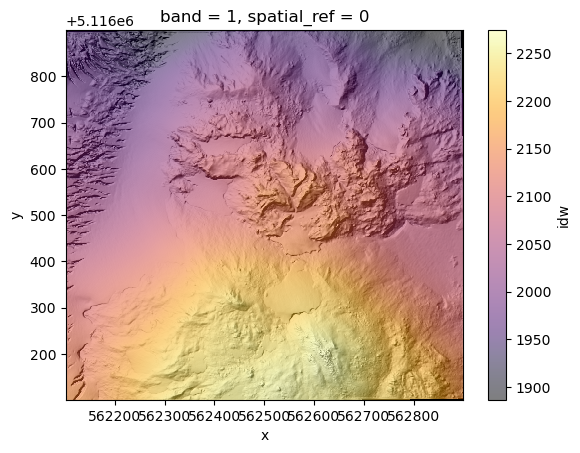

In [30]:
f, ax = plt.subplots()
ds_custom_dtm["hillshade"].squeeze().plot.imshow(cmap='gray', alpha=1, add_colorbar=False)
ds_custom_dtm.band_data.squeeze().plot.imshow(cmap='inferno', alpha=0.5);

Now, let's compare with the provider DEM

In [50]:
da_usgs_dem = coincident.io.xarray.load_usgs_dem(aoi, "WA_FEMAHQ_2018_D18",
                                                 clip=True)

In [51]:
da_usgs_dem

<xarray.DataArray 'elevation' (y: 799, x: 796)> Size: 3MB
dask.array<getitem, shape=(799, 796), dtype=float32, chunksize=(799, 796), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6kB 5.621e+05 5.621e+05 ... 5.629e+05 5.629e+05
  * y            (y) float64 6kB 5.117e+06 5.117e+06 ... 5.116e+06 5.116e+06
    spatial_ref  int64 8B 0

In [55]:
from osgeo import gdal
# probably a better way to do this but this works for deomstrative purposes
temp_path = "/tmp/temp_dem.tif"
da_usgs_dem.rio.to_raster(temp_path)
gdal.Warp("/tmp/usgs_dem.tif", temp_path, srcSRS=input_wkt, dstSRS=output_wkt, format="GTiff")
da_usgs_dem = rxr.open_rasterio("/tmp/usgs_dem.tif").squeeze()

In [59]:
ds_custom_dtm.rio.crs

In [61]:
if da_usgs_dem.rio.crs is None:
    da_usgs_dem.rio.write_crs(output_wkt, inplace=True)
if ds_custom_dtm.rio.crs is None:
    ds_custom_dtm.rio.write_crs(output_wkt, inplace=True)
da_usgs_dem = da_usgs_dem.rio.reproject_match(ds_custom_dtm)

In [64]:
da_usgs_hillshade = coincident.plot.gdaldem(
    da_usgs_dem, "hillshade"
)

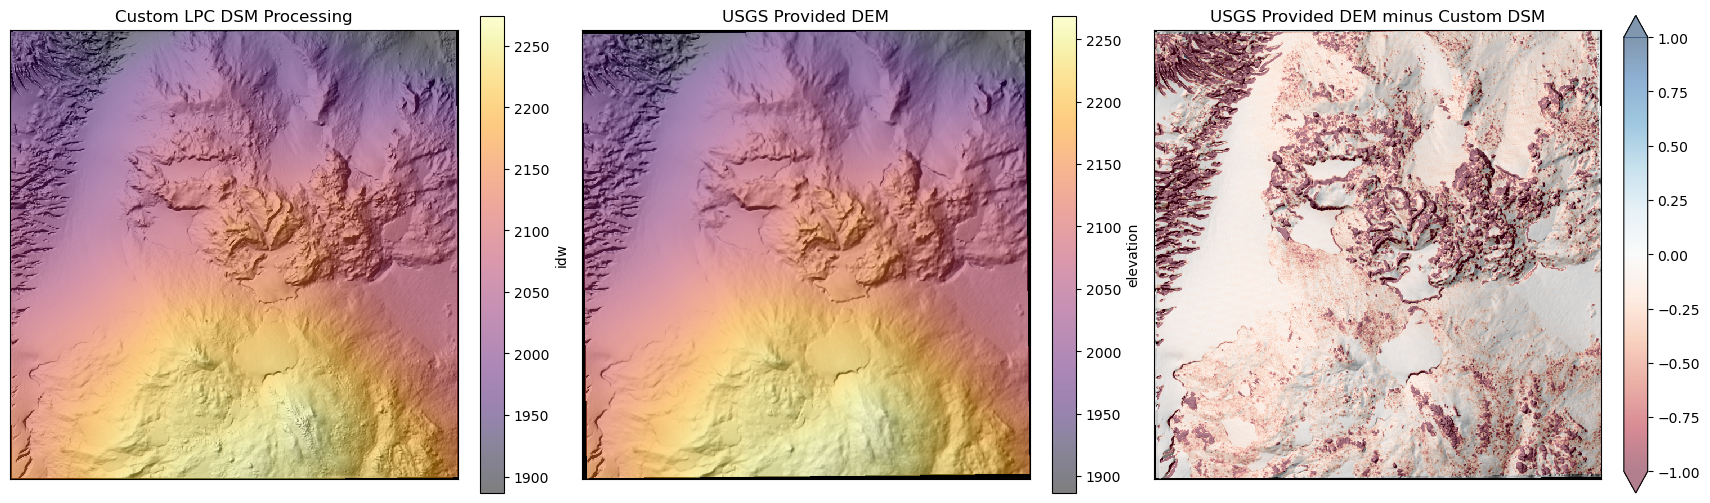

In [68]:
f, axs = plt.subplots(1,3,figsize=(17,5),
                      layout='constrained')

ax=axs[0]
ds_custom_dtm["hillshade"].squeeze().plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
ds_custom_dtm.band_data.squeeze().plot.imshow(ax=ax, cmap='inferno', alpha=0.5)
ax.set_title("Custom LPC DSM Processing")
ax.set_aspect('equal')

ax=axs[1]
da_usgs_hillshade.plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
da_usgs_dem.plot.imshow(ax=ax, cmap='inferno', alpha=0.5)
ax.set_title("USGS Provided DEM")
ax.set_aspect('equal')

ax=axs[2]
da_diff = da_usgs_dem - ds_custom_dtm.band_data.squeeze()
ds_custom_dtm["hillshade"].squeeze().plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
da_diff.plot.imshow(ax=ax, cmap='RdBu', alpha=0.5, vmin=-1, vmax=1)
ax.set_title("USGS Provided DEM minus Custom DSM")
ax.set_aspect('equal')

for ax in axs:
    ax.set(xticks=[],yticks=[],
           ylabel="",xlabel="");